# Figures

In [304]:
from __future__ import division
import os
import nibabel as nb
import numpy as np
import scipy as sp
out_dir = '/home/shared/2018/visual/hcp_cerebellum/'

fig_dir = '/home/shared/2018/visual/hcp_cerebellum/figs/'

try:
    os.mkdir(fig_dir)
except:
    print 'figdir already exists'
    
import h5py
import matplotlib.pyplot as pl
import seaborn as sn
sn.set_style('ticks')
import glob
%matplotlib inline

import colorsys as cs

dims = {
    'ang':0,
    'ecc':1,
    'gain':2,
    'meanvol':3,
    'r2':4,
    'rfsize':5
}
import matplotlib as mpl


%matplotlib inline
mpl.rc_file_defaults()





figdir already exists


In [305]:
print(mpl.matplotlib_fname())


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc


In [306]:
def p_val_from_bootstrap_dist(distribution,test_value=0,two_tailed=True):
    """
    Finds p-value for hypothesis that the distribution is not different 
    from the test_value.

    :param distribution: distribution of bootstrapped parameter
    :type distribution: 1-D array
    :param test_value: value to test distribution against
    :type test_value: float
    :param two_tailed: if True, returns two-tailed test, else one-tailed
    :type two_tailed: bool

    :return p-val: p-val
    :type p-val: float
    """

    # see which part of the distribution falls below / above test value:
    proportion_smaller_than_test_value = np.sum(np.array(distribution) < test_value) / len(distribution)
    proportion_larger_than_test_value = np.sum(np.array(distribution) > test_value) / len(distribution)

    # take minimum value as p-val:
    p = np.min([proportion_smaller_than_test_value,proportion_larger_than_test_value])

    # this yields a one-tailed test, so multiply by 2 if we want a two-tailed p-val:
    if two_tailed:
        p*=2

    return p

def get_ci(distribution,ci_factor):

    from scipy import stats
    
    # convert ci factor to percentile
    perc_low = (stats.norm.sf(ci_factor))*100
    perc_high = (1 - (stats.norm.sf(ci_factor)))*100
    ci_low = np.percentile(distribution,perc_low)
    ci_high = np.percentile(distribution,perc_high)

    return [ci_low,ci_high]

def bootstrap_linear_fit(x_data,y_data,weights=None,test_value=0,ci_factor = 1.96,two_tailed=True,reps=1000):
    """
    Fits linear regression to data, either weighted or not. 
    Returns bootstrapped CIs for slope and intercept


    """
    # # set weights to one if none provided 
    if weights is None:
        weights = np.ones(len(x_data))

    # get random ints for random indices
    permute_indices = np.random.randint(0, len(x_data), size = (len(x_data), int(reps))).T

    slope_bootstrap_distr=[]
    intercept_bootstrap_distr=[]
    # loop over permutes
    for fold in permute_indices:
        # compute weighted linear fit
        slope,intercept=np.polyfit(x_data[fold], y_data[fold], 1,w=weights[fold])
        slope_bootstrap_distr.append(slope)
        intercept_bootstrap_distr.append(intercept)

    # get centers for slope and intercept by fitting to all data
    mean_slope,mean_intercept=np.polyfit(x_data, y_data, 1,w=weights)
    # slope distribution diagnostics
    ci_slope = get_ci(slope_bootstrap_distr,ci_factor)
    # ci_slope = np.std(slope_bootstrap_distr)*ci_factor
    p_slope = p_val_from_bootstrap_dist(slope_bootstrap_distr,test_value,two_tailed)

    # intercept distribution diagnostics
    # ci_intercept = np.std(intercept_bootstrap_distr)*ci_factor
    ci_intercept = get_ci(intercept_bootstrap_distr,ci_factor)
    p_intercept = p_val_from_bootstrap_dist(intercept_bootstrap_distr,test_value,two_tailed)

    return mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept

# define rois

In [312]:
masktype = 'r2_spill_fix'

# mask_names ={
# 'left_VI':1,
# 'right_VI':5,
# 'left_VIIb':2,
# 'right_VIIb':7,
# 'left_VIIIb':3,
# 'right_VIIIb':6,
# 'left_crusI':4,
# }

mask_names ={
'left_mOMV':7,
'right_mOMV':9,
'left_lOMV':8,
'right_lOMV':10,
    
'left_VIIb':5,
'right_VIIb':6,
    
'left_mVIIIb':3,#
'right_mVIIIb':2,#
'left_lVIIIb':4,#
'right_lVIIIb':1, #
}

roi_combs = {
    'left_OMV':[7,8],
    'right_OMV':[9,10],
    'left_VIIb':[5],
    'right_VIIb':[6],
    'left_VIIIb':[3,4],
    'right_VIIIb':[1,2],

    'OMV':[7,8,9,10],
    'lOMV':[8,10],
    'mOMV':[7,9],
    'VIIb':[5,6],
    'VIIIb':[1,2,3,4],
    'lVIIIb':[1,4],
    'mVIIIb':[2,3],
}

stim_radius = 8
sub_types = ['avg']#,'wavg','per']
# n_vox_per = 250#

roi_order = ['left_mOMV','right_mOMV','left_lOMV','right_lOMV','left_VIIb','right_VIIb','left_mVIIIb','right_mVIIIb','left_lVIIIb','right_lVIIIb']
roi_comb_order = ['mOMV','lOMV','VIIb','mVIIIb','lVIIIb']
           
           

In [308]:
def get_ecc_lim(mask,sub_type,plot_type=None):
    
    if plot_type == None:
        plot_type = 'zoomed_in'
        
    # determine ecc limit
    if plot_type == 'zoomed_out':
        maxecc = 8
    elif plot_type == 'zoomed_in':
        if (mask in ['left_lOMV','right_lOMV','left_mOMV','right_mOMV','mOMV','lOMV']):
            if sub_type == 'avg':
                maxecc = 8
            elif sub_type == 'per':
                maxecc=8
            elif sub_type == 'wavg':
                maxecc = 3
        elif mask in ['VIIb','left_VIIb','right_VIIb']:
            if sub_type == 'per':
                maxecc = 8
            else:
                maxecc = 8
        elif (mask in ['left_lVIIIb','right_lVIIIb','left_mVIIIb','right_mVIIIb','mVIIIb','lVIIIb']):
            maxecc = 8
            
    if mask == 'visual':
        maxecc = 8
    elif mask == 'lateral':
        maxecc = 2
    elif mask == 'IPS':
        maxecc = 8
    elif mask == 'iPCS':
        maxecc = 0.5
    elif mask == 'sPCS':
        maxecc = 2
    elif mask == 'postCS':
        maxecc = 1  
    return maxecc


def get_roi_color(mask):
    # determine roi color
    if mask in ['left_OMV','right_OMV','OMV']:
        c = '#6590CB'
    elif mask in ['left_VIIIb','right_VIIIb','VIIIb']:
        c = '#E55D5C'
    elif ('VIIb' in mask) + (mask=='VIIb'):
        c = '#E79F2A'
        
    elif mask in ['left_lOMV','right_lOMV','lOMV']:
        c = '#6590CB'
    elif mask in ['left_mOMV','right_mOMV','mOMV']:
        c = '#0D5B99'

    elif mask in ['left_mVIIIb','right_mVIIIb','mVIIIb']:
        c = '#C03142'
    elif mask in ['left_lVIIIb','right_lVIIIb','lVIIIb']:
        c = '#E57F80'
    else:
        c = 'k'
        print 'could not find mask %s for picking color'%mask
    return c
    
def get_size_lim(mask,sub_type):
    if mask in ['mOMV','lOMV']:
        if sub_type in ['avg','wavg']:
            max_size= 2
        elif sub_type == 'per':
            max_size = 5
    elif mask == 'VIIb':
        if sub_type in ['avg','wavg']:
            max_size= 5
        elif sub_type == 'per':
            max_size = 10
    elif mask in ['lVIIIb','mVIIIb']:
        if sub_type in ['avg','wavg']:
            max_size= 10
        elif sub_type == 'per':
            max_size = 10
            
    return max_size

def two_d_gauss(xo, yo, sigma, amplitude = 1, theta=0,res=101,max_eccentricity=8):


    X = np.linspace(-max_eccentricity, max_eccentricity, res)
    Y = np.linspace(-max_eccentricity, max_eccentricity, res)
    MG = np.meshgrid(X, Y)

    (x,y) = MG    
    a = (np.cos(theta)**2)/(2*sigma**2) + (np.sin(theta)**2)/(2*sigma**2)
    b = -(np.sin(2*theta))/(4*sigma**2) + (np.sin(2*theta))/(4*sigma**2)
    c = (np.sin(theta)**2)/(2*sigma**2) + (np.cos(theta)**2)/(2*sigma**2)
    gauss = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

    return gauss

# visualize pRF center + size distribution

In [313]:

# scatter plot
pl.close('all')
for sub_type in sub_types:
    for plot_type in ['zoomed_in','zoomed_out']:

        f = pl.figure(figsize=(2,4.5))

        for mi,mask in enumerate(roi_order):
            s = f.add_subplot(5,2,mi+1,aspect='equal')


            roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data()==(mask_names[mask]))

            if sub_type in ['avg','wavg']:

                alpha = 1
                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
                xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                sizes = np.ravel(data[roimask,dims['rfsize']])
                r2s = np.ravel(data[roimask,dims['r2']])


            elif sub_type == 'per':

                alpha = 1#0.1

                all_xs = []
                all_ys = []
                all_sizes=[]

                all_r2s=[]

                for sj in range(181):

                    data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

                    xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                    ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                    sizes = np.ravel(data[roimask,dims['rfsize']])
                    r2s = np.ravel(data[roimask,dims['r2']])

                    all_xs.append(xs)
                    all_ys.append(ys)
                    all_sizes.append(sizes)
                    all_r2s.append(r2s)


                xs = np.ravel(all_xs)
                ys = np.ravel(all_ys)                    
                sizes = np.ravel(all_sizes)                    
                r2s = np.ravel(all_r2s)                    

            v = (sizes>0)
            if sub_type == 'per':
                indices = np.hstack([np.ones(n_vox_per),np.zeros(v.sum()-n_vox_per)]).astype(bool)
                np.random.shuffle(indices)          
                v[v==True] *= indices

            # determine ecc limit and roi color
            maxecc = get_ecc_lim(mask,sub_type,plot_type)
            c = get_roi_color(mask)

            stim_radius = maxecc
            for x,y,sigma,r2 in zip(xs[v],ys[v],sizes[v],r2s[v]):
                s.add_artist(pl.Circle((x,y),sigma, color=c,fill=False,alpha=0.25))

#             if scope > 1:
#                 s.add_artist(pl.Circle((res/2,res/2),res/2/scope, color='c',fill=False))

            pl.axhline(0,lw=0.5,color='k')
            pl.axvline(0,lw=0.5,color='k')

            pl.plot(xs[v],ys[v],'o',color=c,ms=3,mec='w',mew=1,alpha=alpha)
            pl.xlim(-maxecc,maxecc)
            pl.ylim(-maxecc,maxecc)   

#             pl.ylabel('x')
            if mask =='left_lVIIIb':
                pl.xticks([-maxecc,0,maxecc],['-%d'%maxecc,0,'%.d'%maxecc])
                pl.yticks([-maxecc,0,maxecc],['-%d'%maxecc,0,'%.d'%maxecc])
                sn.despine(offset=2)
            elif mask =='right_lVIIIb':
                pl.xticks([-maxecc,0,maxecc],['-%.d'%maxecc,0,'%.d'%maxecc])
                pl.yticks([])
                sn.despine(offset=2,left=True)
            else:
                pl.axis('off')
                pl.xticks([])
                pl.yticks([])                

#             pl.axis('off')
        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'prf_scatter_avg_subject_%s_%s.pdf'%(plot_type,sub_type)))#,dpi=500)

# create eccentricity-size plot

In [230]:
# eccen-size plot
this_roi_comb_order = ['mVIIIb','lVIIIb','VIIb','mOMV','lOMV']
for sub_type in sub_types:#['per']:#['wavg','avg','per']:
    f = pl.figure(figsize=(1.25,1.25))
    s = f.add_subplot(111)
    
    all_max_eccs = []
    all_max_sizes=[]
    for mi,mask in enumerate(this_roi_comb_order):
#         f = pl.figure(figsize=(1.5,1.5))
#         s = f.add_subplot(1,1,1)

        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data())

        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        
        roimask = roimask.astype(bool)
        
        # determine ecc limit and roi color
        maxecc = get_ecc_lim(mask,sub_type)
        maxplotsize = get_size_lim(mask,sub_type)
        c = get_roi_color(mask)  

        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            sizes = np.ravel(data[roimask,dims['rfsize']])
            eccs = np.ravel(data[roimask,dims['ecc']])
        
        elif sub_type == 'per':

            all_sizes = []
            all_eccs = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_sizes.append(np.ravel(data[roimask,dims['rfsize']]))
                all_eccs.append(np.ravel(data[roimask,dims['ecc']]))
            eccs = np.ravel(all_eccs)
            sizes = np.ravel(all_sizes)  

        elif sub_type == 'fits_per':
            all_fits = []
            for sj in range(181):
                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                r2s = np.ravel(data[roimask,dims['r2']])
                sizes = np.ravel(data[roimask,dims['rfsize']])
                eccs = np.ravel(data[roimask,dims['ecc']])
                v = (eccs < maxecc)#*(sizes<maxsize)

                if v.sum() > 2:
                    p=np.polyfit(eccs[v], sizes[v], 1,w=r2s[v])
                    fit = np.polyval(p,np.linspace(0,maxecc,15))
                    all_fits.append(fit)
            
#             print np.shape(all_fits)
            meanfit = np.mean(all_fits,axis=0)
            sefit = (np.std(all_fits,axis=0)*1.96)/np.sqrt(np.shape(all_fits)[0])
            pl.plot(np.linspace(0,maxecc,15),meanfit,color=c)
            pl.fill_between(np.linspace(0,maxecc,15),meanfit-sefit,meanfit+sefit,alpha=0.5,color=c)
            
#         from scipy.stats import binned_statistic
        import scipy.stats as sp
        
        if sub_type != 'fits_per':
            maxecc = np.min([np.nanmax(eccs),stim_radius])


            v = (eccs < maxecc)
            
            r,p=sp.pearsonr(eccs[v],sizes[v])
            print '%s %s R: %.2f, p: %.6f'%(sub_type,mask,r,p)
            
            mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])            
            fit = np.polyval([mean_slope,mean_intercept],np.linspace(0,maxecc,15))
            fit_high = np.polyval([ci_slope[0],ci_intercept[1]],np.linspace(0,maxecc,15))
            fit_low = np.polyval([ci_slope[1],ci_intercept[0]],np.linspace(0,maxecc,15))

            pl.plot(np.linspace(0,maxecc,15),fit,color=c,lw=2)
            pl.fill_between(np.linspace(0,maxecc,15),fit_low,fit_high,alpha=0.25,color=c)
        
        all_max_eccs.append(maxecc)
        all_max_sizes.append(maxplotsize)

    pl.xlim(0,np.max(all_max_eccs))  
    pl.ylim(0,np.max(all_max_sizes))
    pl.xticks([0,np.max(all_max_eccs)])
    pl.yticks([0,np.max(all_max_sizes)])
    
    
#     pl.ylabel('size (dva)')
#     pl.xlabel('eccen (dva)')

    sn.despine(offset=2)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'prf_eccsize_%s.pdf'%(sub_type)))#,dpi=500)

avg mVIIIb R: 0.63, p: 0.000000
avg lVIIIb R: 0.85, p: 0.000000
avg VIIb R: 0.85, p: 0.000000
avg mOMV R: 0.73, p: 0.000000
avg lOMV R: -0.29, p: 0.003261


# create eccentricity histogram

In [231]:
# ecc histogram
# from statsmodels.nonparametric.kernel_density import KDEMultivariate as kdem
# from sklearn.neighbors import KernelDensity
# from scipy.stats import gaussian_kde as kd
# import statsmodels.nonparametric.api as smnp

import pandas as pd
for sub_type in sub_types:

    f = pl.figure(figsize=(1.25,2))
    s = f.add_subplot(111)
    dc = pd.DataFrame()
    colors = []

    # first create a plot for the average subject
    for mi,mask in enumerate(roi_comb_order):
#         s = f.add_subplot(len(roi_comb_order),1,mi+1)


        # setup figure
#         f = pl.figure(figsize=(2,1.25))
#         s = f.add_subplot(1,1,1)
        
        # get mask
        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data())
        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        roimask = roimask.astype(bool)

        # get data
        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            eccs = np.ravel(data[roimask,dims['ecc']])
#             print("%s %s")

        elif sub_type == 'per':
            all_eccs = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_eccs.append(np.ravel(data[roimask,dims['ecc']]))

            eccs = np.ravel(all_eccs)
                
#         maxecc = get_ecc_lim(mask,sub_type)
#         maxplotsize = get_size_lim(mask,sub_type)
        c = get_roi_color(mask)
        colors.append(c)
        these_eccs = eccs[~np.isnan(eccs)].astype(np.float64)
        these_eccs = np.hstack([these_eccs,np.ones(100000-len(these_eccs))*np.nan])
        dc[mask] = np.array(these_eccs)
#         sn.kdeplot(these_eccs,color=c,shade=True,alpha=1)
#         pl.xlim(0,stim_radius)
#         pl.xticks([0,stim_radius])
#         sn.despine(offset=2)
#         pl.xticks([])#'off')
#         pl.yticks([])
        #,left=True)
#     pl.xlabel('eccen (dva)')        
#         sn.violinplot(x=mi,y=these_eccs,color=c)
#         kde = smnp.KDEUnivariate(data)#[:, np.newaxis])
# #         kde.fit(cut=3,clip=(-np.inf,np.inf))#bw="scott",gridsize=100)
# #         kernel = "gau"
# #         fft = kernel == "gau"
# #         bw="scott"
#         kde.fit(bw="scott", gridsize=100)
        
#         x, y = kde.support, kde.density
#         y/=np.max(y)
#         pl.plot(x,y,color=c)#,alpha=0.25)
#         pl.fill_between(x,np.zeros_like(y),y,color=c,alpha=0.5)

        
#         sn.kdeplot(data)
        
        
        #         x, y = _statsmodels_univariate_kde(data, kernel, bw,
#                                            gridsize, cut, clip,
#                                            cumulative=cumulative)
#         X = eccs[~np.isnan(eccs)][:, np.newaxis]
#         X_plot = np.linspace(np.min(X),np.max(X),100)[:, np.newaxis]
#         kdem = KernelDensity(kernel='gaussian',bandwidth=0.35).fit(X)
#         kde = np.exp(kdem.score_samples(X_plot))
    
#         kde = kdem(eccs[~np.isnan(eccs)],var_type='c').pdf()
#         try: 
#             sn.distplot(eccs[~np.isnan(eccs)],kde_kws={'shade':False,'color':c},hist=False,norm_hist=True)#,,hist=False,norm_hist=True)#,color = ['b'])
#         except:
#             print 'could not plot'
#         kde /= np.max(kde)
#         pl.plot(x,y,color=c)
#         pl.fill_between(X_plot[:,0],np.zeros_like(kde),kde,color=c,alpha=0.25)
            
#         pl.axvline(maxecc,ls='--',color=c,lw=0.5) 
#     pdc = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dc.iteritems() ]))
    sn.violinplot(data=dc,palette=colors,scale='width',orient='h',linewidth=0)#alpha=0.1,scale='width'
#     pl.xlim(0,stim_radius)
#     pl.ylim(0,s.get_ylim()[1])
#     pl.xticks([0,stim_radius])
#     pl.yticks([0,1])
#     pl.ylabel('density')
#     pl.xlabel('eccen (dva)')
    pl.xlim(0,stim_radius)
    pl.xticks([0,stim_radius])
    sn.despine(offset=2)#,left=True)
    pl.xlabel('eccen (dva)')

    pl.tight_layout(pad=0)
    f.savefig(os.path.join(fig_dir,'ecc_histograms_%s.pdf'%(sub_type)),dpi=500)
    
    

# polar histogram

In [232]:
# polar histogram
for sub_type in sub_types:

    for hemi in ['left','right']:
        f = pl.figure(figsize=(0.75,4.5))

        for mi,roi in enumerate(['mOMV','lOMV','VIIb','mVIIIb','lVIIIb']):
            mask = hemi+'_'+roi
            s = f.add_subplot(5,1,mi+1,projection='polar')
            roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data()==(mask_names[mask]))


            c = get_roi_color(mask)

            if sub_type in ['avg','wavg']:

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
                angles = np.ravel(data[roimask,dims['ang']])

            elif sub_type == 'per':
                all_angles = []
                for sj in range(181):

                    data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                    all_angles.append(np.ravel(data[roimask,dims['ang']]))

                angles = np.ravel(all_angles)

            angles = angles[~np.isnan(angles)]

            bins_number = 12
            bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
            radangs = np.radians(angles)
            n, _, _ = pl.hist(radangs, bins)

            width = 2 * np.pi / bins_number
            pl.bar(bins[:bins_number], n, width=width, bottom=0.0,ec=c,color=c)
    #         for bar in bars:
    #             bar.set_alpha(0.5)
            pl.xticks([])
            pl.yticks([])
            pl.ylim(0,np.max(n))

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'polar_histograms_%s_%s.pdf'%(sub_type,hemi)))

# individual subject plots

In [231]:
# # import colorsys
# # colors = np.array([colorsys.hsv_to_rgb(c,0.6,0.9) for c in np.linspace(0,1,12)])[:-2]

# f = pl.figure(figsize=(2,2))
# coefs = []

# for sj in range(5):
#     for ei, eccrange in enumerate([8,12]):

#         s = f.add_subplot(1,2,ei+1)

#         # first create a plot for the average subject
#         data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

#         eccs = data[roimask,dims['ecc']]
#         sizes = data[roimask,dims['rfsize']]

#         v = (eccs<eccrange)*(~np.isnan(eccs))
#         mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])
        
#         x = np.linspace(0,eccrange,10)
        
#         fit = mean_intercept + mean_slope * x
#         high_fit = ci_intercept[1] + ci_slope[1] * x
#         low_fit = ci_intercept[0] + ci_slope[0] * x

#         pl.fill_between(x,high_fit,low_fit,color=colors[sj],alpha=0.1)
#         pl.plot(x,fit,c=colors[sj])
        
#         print 'slope is %.3f greater than 0 with p = %.3f'%(mean_slope,p_slope)

# #         pl.plot(x,c.intercept_[0]+c.coef_[0][0]*x,c=colors[si])


#     #         sn.regplot(eccs[v],sizes[v],color = ['b','k'][ei])
#     #         # pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

#         pl.xlim(0,eccrange)
#         pl.ylim(0,maxsize)
#         pl.xticks([0,eccrange])
#         pl.yticks([0,maxsize])
#         sn.despine(offset=10)
    
# pl.tight_layout()
# f.savefig(os.path.join(fig_dir,'ecc_size_all_subjects_together.pdf'))     

In [253]:

# eccen-size plot
for sgi,sjg in zip([range(5),range(88,93),range(176,181)],['high','mid','low']):
    for mi,mask in enumerate(roi_comb_order):
        f = pl.figure(figsize=(0.75,0.75))
        s = f.add_subplot(1,1,1)

        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data())

        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data()==subroi)
            roimask[this_mask] = 1

        roimask = roimask.astype(bool)

        # determine ecc limit and roi color
        maxecc = stim_radius#get_ecc_lim(mask,sub_type)
        maxplotsize = 10#get_size_lim(mask,sub_type)
        c = get_roi_color(mask)  

        for sj in sgi:

            try:
                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                sizes = np.ravel(data[roimask,dims['rfsize']])
                eccs = np.ravel(data[roimask,dims['ecc']])
                v = (eccs < maxecc)#*(sizes<maxsize)

                mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])            
                fit = np.polyval([mean_slope,mean_intercept],np.linspace(0,maxecc,15))
                fit_high = np.polyval([ci_slope[1],ci_intercept[0]],np.linspace(0,maxecc,15))
                fit_low = np.polyval([ci_slope[0],ci_intercept[1]],np.linspace(0,maxecc,15))

                pl.plot(np.linspace(0,maxecc,15),fit,color=c)
                pl.fill_between(np.linspace(0,maxecc,15),fit_low,fit_high,alpha=0.1,color=c)
            except:
                print 'could not fit'

        pl.xlim(0,maxecc)  
        pl.ylim(0,maxplotsize)
        pl.xticks([0,maxecc])
        pl.yticks([0,maxplotsize])

        sn.despine(offset=2)

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'prf_eccsize_all_%s_%s.pdf'%(sjg,mask)))

could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit
could not fit


In [238]:
def circnanmean(data, axis=None, w=None):
    
    data = np.array(data)
    
    if w is None:
        w = np.ones(data.shape)

    # weight sum of cos & sin angles
    t = w * np.exp(1j * data)
    r = np.nansum(t, axis=axis)

    # obtain mean by
    mu = np.angle(r)

    return mu

# volumnar polar gradients

In [58]:
import copy
pl.close('all')
for mi,mask in enumerate(roi_comb_order):
    
    roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data())

    for subroi in roi_combs[mask]:
        this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data()==subroi)
        roimask[this_mask] = 1
    roimask = roimask.astype(bool)

    # first let's try this out with the avg subject
    data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_avg.nii')).get_data()
    data[np.invert(roimask)] = np.nan
    r2s = data[:,:,:,dims['r2']]
    angles = np.radians(data[:,:,:,dims['ang']])

    # first create the 2d means
    xmean = circnanmean(angles,axis=0,w=r2s)
    xr2 = np.nanmean(r2s,axis=0)
    ymean = circnanmean(angles,axis=1,w=r2s)
    yr2 = np.nanmean(r2s,axis=1)
    zmean = circnanmean(angles,axis=2,w=r2s)
    zr2 = np.nanmean(r2s,axis=2)
    
    z = circnanmean(xmean,axis=0,w=xr2)
    z2 = copy.copy(z)#circnanmean(ymean,axis=0,w=yr2)
    y = circnanmean(xmean,axis=1,w=xr2)
    y2 = copy.copy(y)#circnanmean(zmean,axis=0,w=zr2)
    x = circnanmean(ymean,axis=1,w=yr2)
    x2 = copy.copy(x)#circnanmean(zmean,axis=1,w=zr2)
    
#     print np.min(x)
#     print np.max(x)
    
    # first rescale data so it goes from 0-2pi
#     z[z<0] = np.pi*2 + z[z<0]# + +avg_angle[avg_angle <0]np.pi*2
#     y[y<0] += np.pi*2
#     x[x<0] += np.pi*2

#     # rotate data so 0 is above
    z -= np.pi/2
    y -= np.pi/2
    x -= np.pi/2

    # fix the negative angles again
    z[z<(-np.pi)] += np.pi*2
    y[y<(-np.pi)] += np.pi*2
    x[x<(-np.pi)] += np.pi*2
       
#     z[z==-np.pi/2] = 0
#     y[y==-np.pi/2] = 0
#     x[x==-np.pi/2] = 0


    z[z == -np.pi/2] = np.nan
    y[y == -np.pi/2] = np.nan
    x[x == -np.pi/2] = np.nan

    midx = np.shape(data)[0]/2
    midy = np.shape(data)[1]/2
    midz = np.shape(data)[2]/2

    
    f = pl.figure()
    s = f.add_subplot(311)
#     xx = np.arange(len(x))
#     valid_x = (x!=-np.pi/2)    
    pl.plot(x,'o')
    pl.axhline(0,c='k',ls='--')
    pl.ylim([-np.pi,np.pi])
    sn.despine(offset=2)
    pl.axvline(midx,c='k',ls='--')

#     pl.plot(xx[valid_x],x2[valid_x],'o')
    s = f.add_subplot(312)
#     yx = np.arange(len(y))
#     valid_y = (y!=-np.pi/2)    
    pl.plot(y,'o')
#     pl.axvline(midy,c='k',ls='--')

    pl.axhline(0,c='k',ls='--')
    pl.ylim([-np.pi,np.pi])
    sn.despine(offset=2)#     pl.plot(yx[valid_y],y2[valid_y],'o')
    s = f.add_subplot(313)
#     zx = np.arange(len(z))
#     valid_z = (z!=-np.pi/2)    
    pl.plot(z,'o') 
#     pl.axvline(midz,c='k',ls='--')

 
#      pl.plot(zx[valid_z],z2[valid_z],'o')
    pl.axhline(0,c='k',ls='--')
    pl.ylim([-np.pi,np.pi])
    sn.despine(offset=2)
    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'avgangledim_%s.png'%(mask)),dpi=500)

# flatmap data

In [255]:
def rotate_via_numpy(x,y, radians):
    """Use numpy to build a rotation matrix and take the dot product."""
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, np.matrix([x, y]))

    return m

In [256]:
kernel = 6 # percentage of data in single average operation

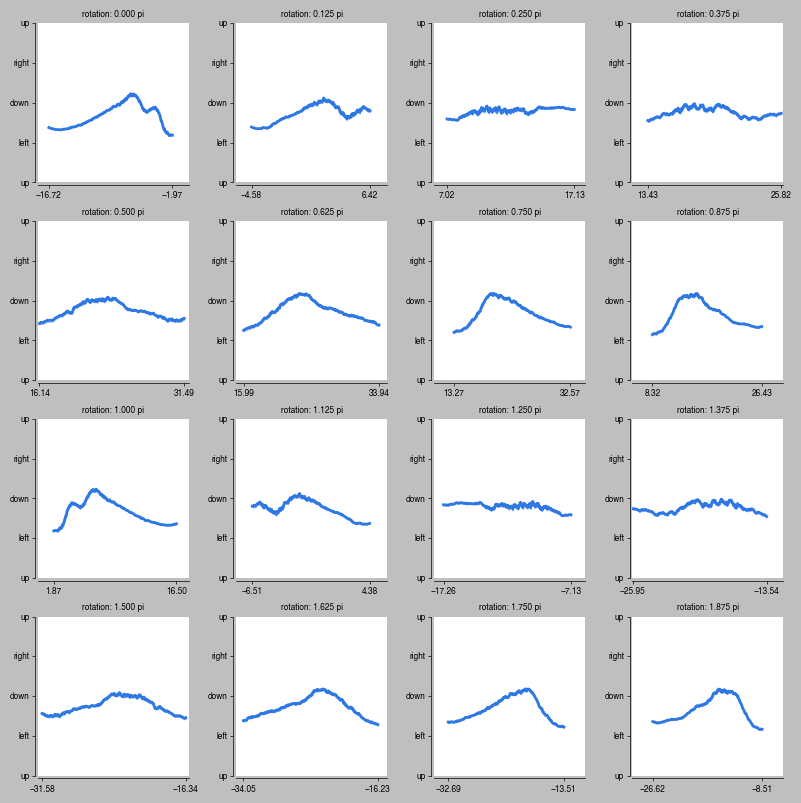

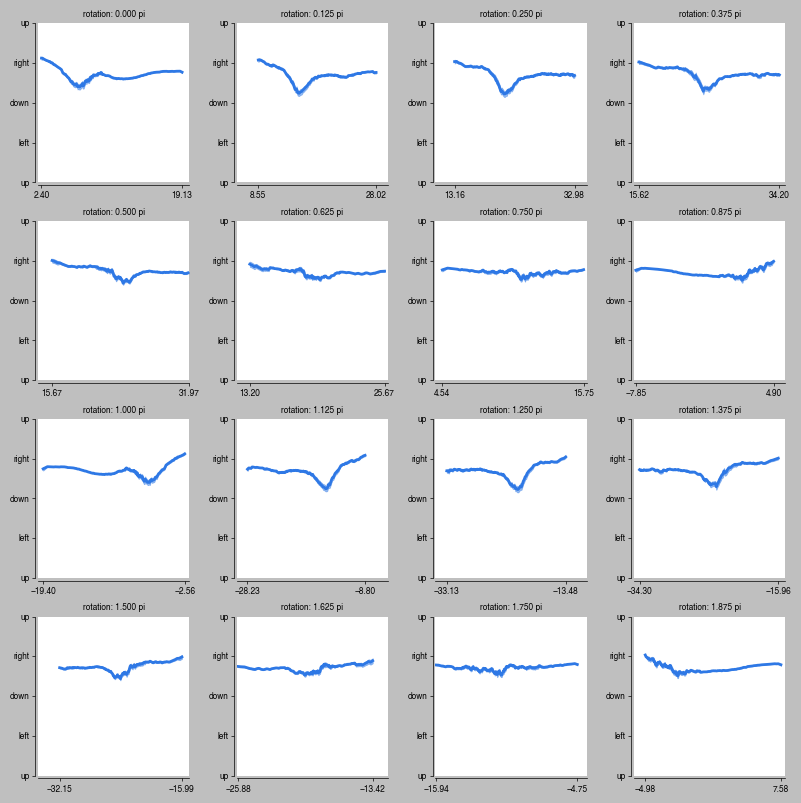

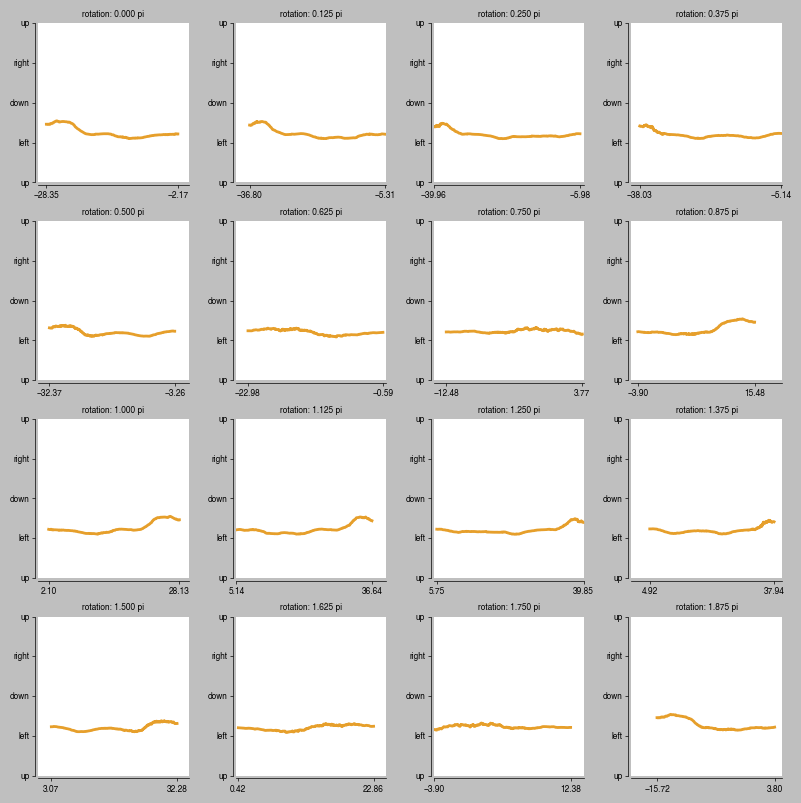

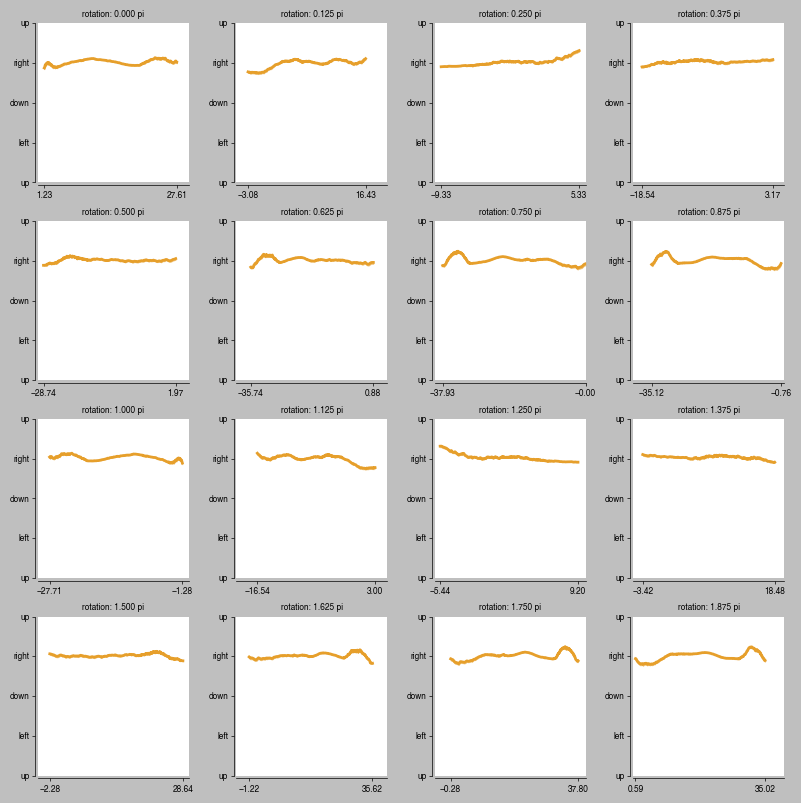

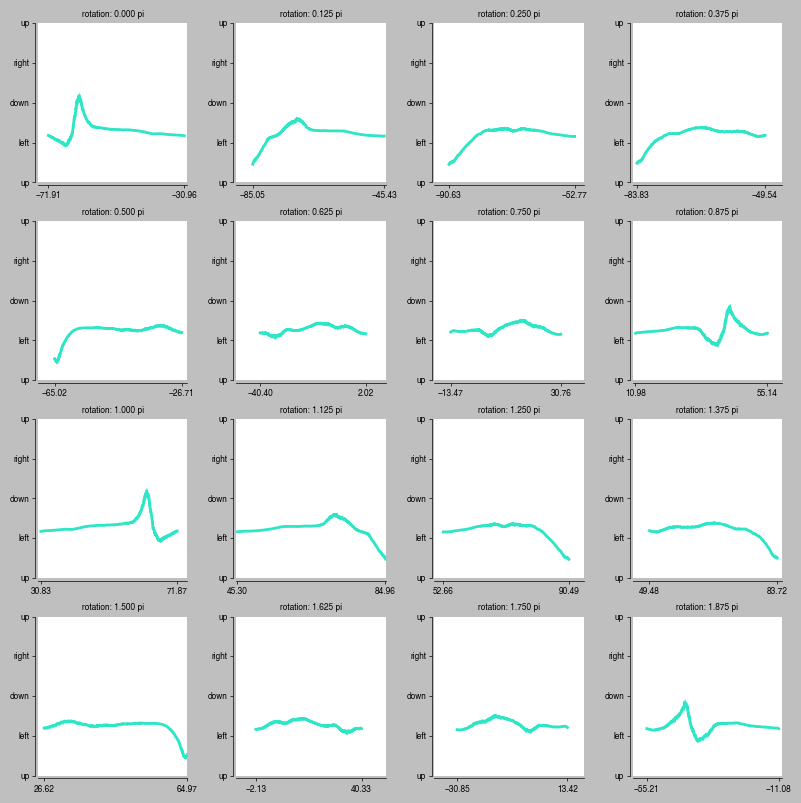

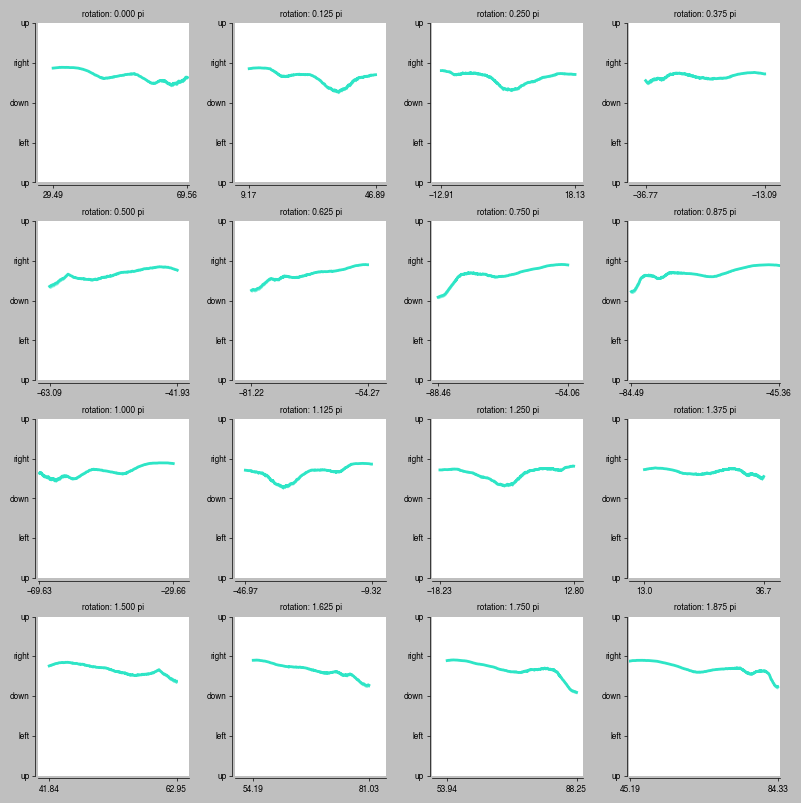

In [401]:
import pandas as pd
import pycircstat as pc

angles=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ang_avgdata_r2_spill_fix.csv'),header=None))
r2=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','r2_avgdata_r2_spill_fix.csv'),header=None))
masks=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ang_avgmasks_r2_spill_fix.csv'),header=None))
coords=nb.load(os.path.join(out_dir,'flatdata','FLAT.coord.gii'))
x = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,0]) 
y = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,1]) 


# rotate angles so 0 is up
angles += 1.5*np.pi
angles = np.mod(angles,np.pi*2)

# create 1 figure for each mask with 3 different rotations
for mask in roi_order:
    
    f= pl.figure(figsize=(8,8))
    for ri,rotation in enumerate(np.linspace(0,2,16,endpoint=False)):
        s = f.add_subplot(4,4,ri+1)
        pl.title('rotation: %.3f pi'%rotation)
        c = get_roi_color(mask)  


        rx = np.ravel(rotate_via_numpy(x,y,rotation*np.pi)[0])
        v = (masks==mask_names[mask])
        v *= (np.invert(np.isnan(angles)))
#         pl.plot(rx[v],angles[v],'o',alpha=0.1,color=c,mec='w')

        # create moving average
        # first sort values based on x
        order = np.argsort(rx[v])
        xo = rx[v][order]
        yo = angles[v][order]
        wo = r2[v][order]
        kw = int(v.sum()/kernel)

        ma_x = np.array([np.nanmean(xo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the x coords
        ma_y = np.array([pc.mean(yo[i:i+kw],w=wo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the angles
        ma_ci = np.array([pc.mean_ci_limits(yo[i:i+kw],w=wo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the angles

        pl.plot(ma_x,ma_y,lw=2,color=c)
        pl.fill_between(ma_x,ma_y-ma_ci,ma_y+ma_ci,alpha=0.5,color=c)
        
        pl.ylim(0,np.pi*2)
        pl.yticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],['up','left','down','right','up'])
        pl.xticks([np.min(ma_x),np.max(ma_x)])
        sn.despine(offset=2)
        
    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'anglesurf_%s.pdf'%mask))#,dpi=500)


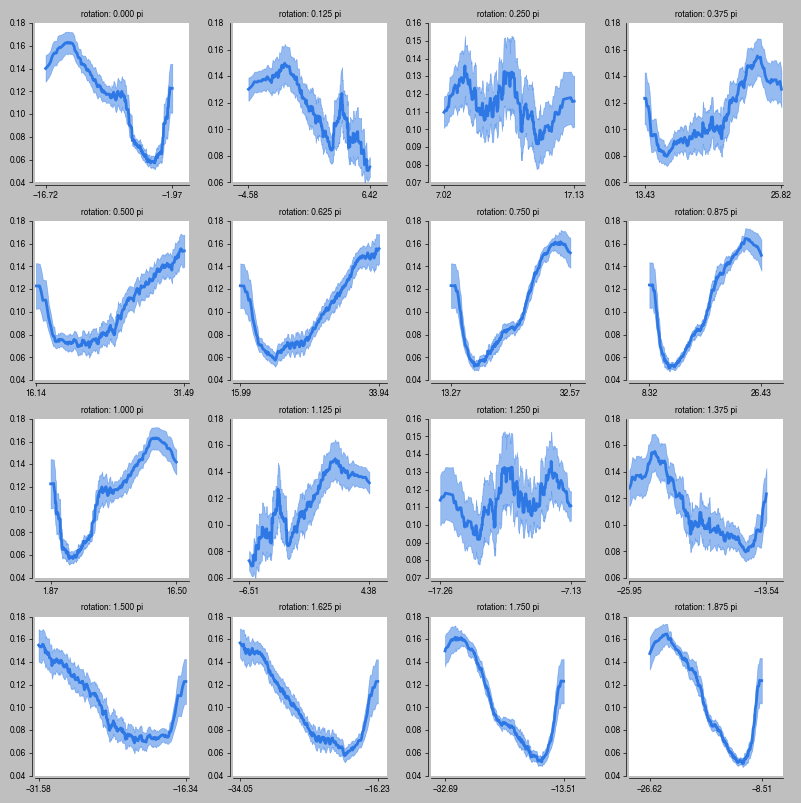

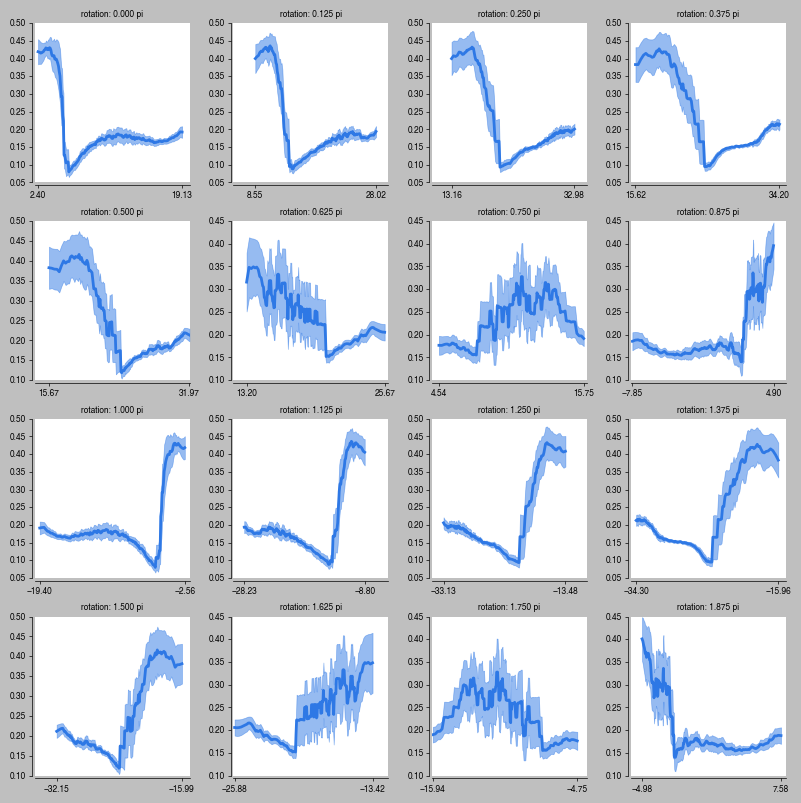

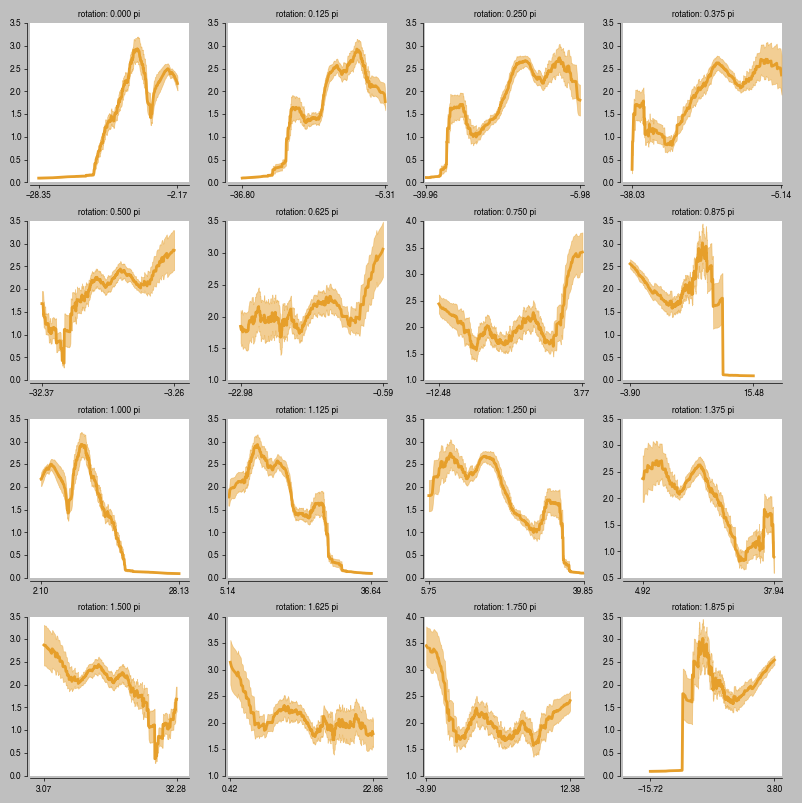

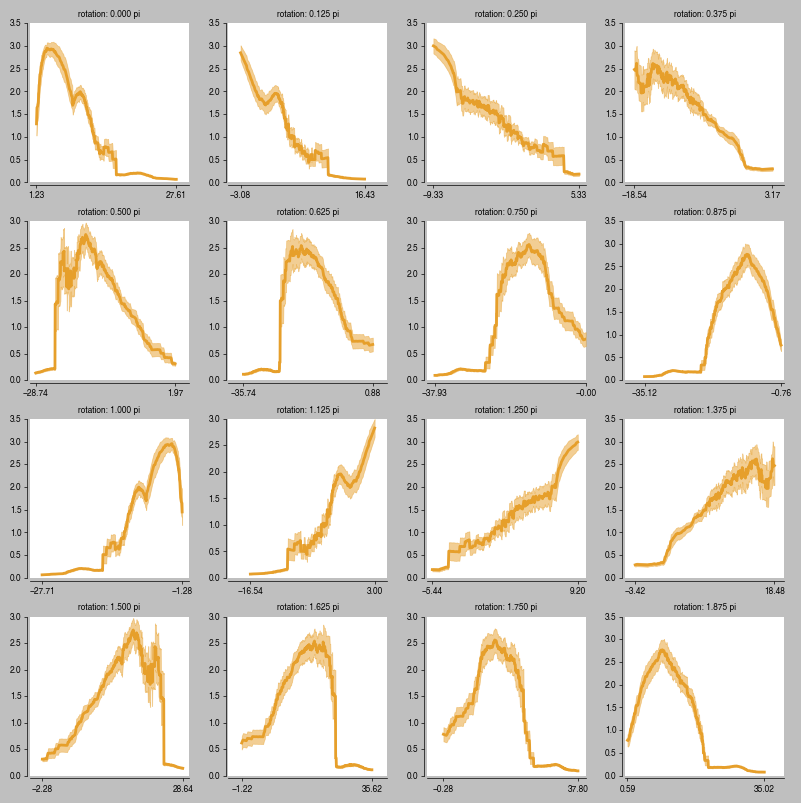

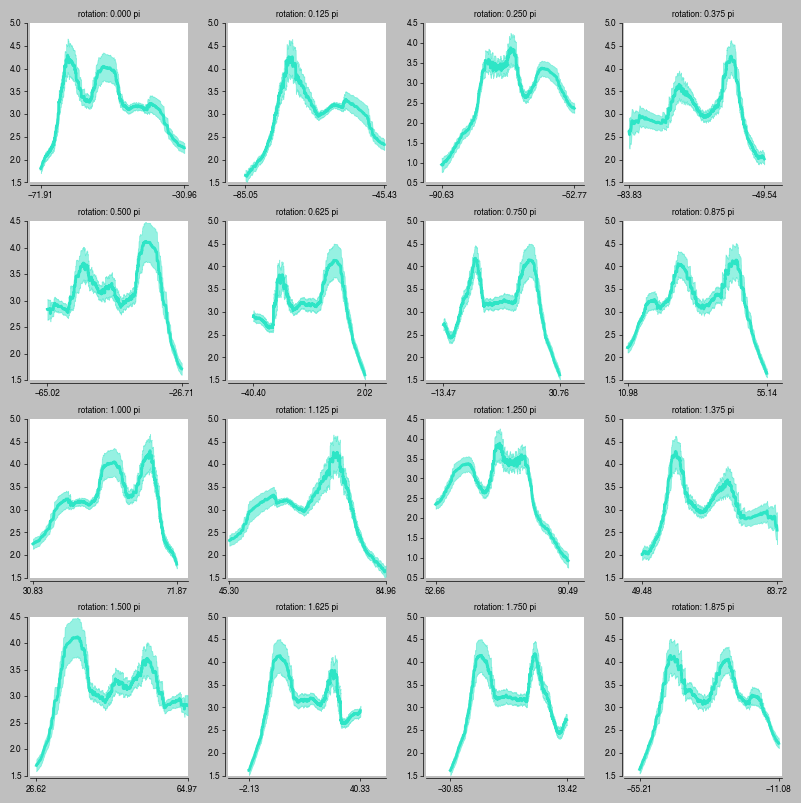

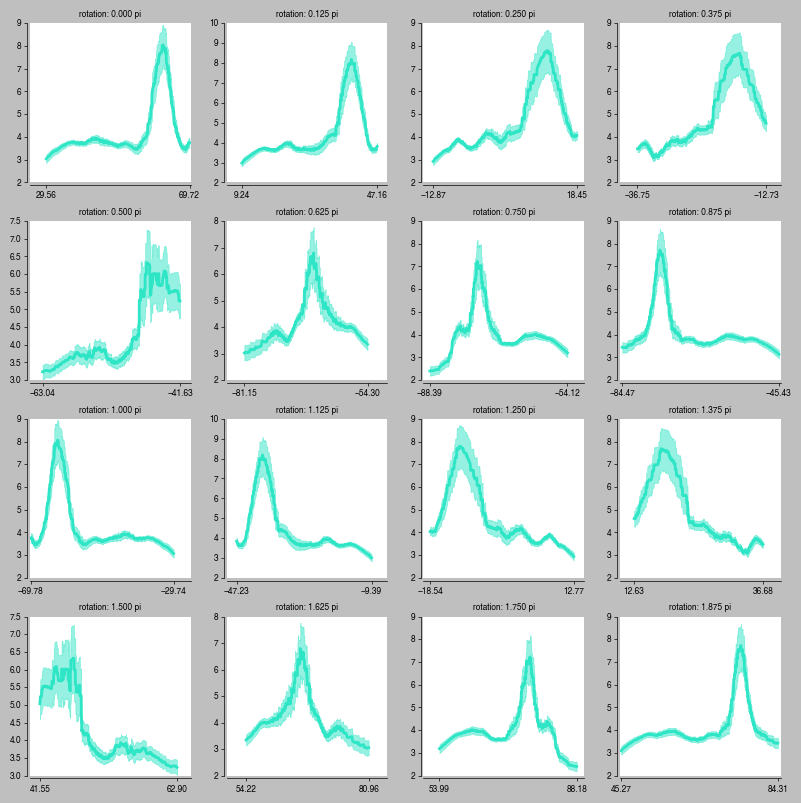

In [403]:
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW


angles=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ecc_avgdata_r2_spill_fix.csv'),header=None))
r2=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','r2_avgdata_r2_spill_fix.csv'),header=None))


masks=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ang_avgmasks_r2_spill_fix.csv'),header=None))
coords=nb.load(os.path.join(out_dir,'flatdata','FLAT.coord.gii'))
x = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,0]) 
y = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,1]) 

# create 1 figure for each mask with 3 different rotations
for mask in roi_order:
    
    f= pl.figure(figsize=(8,8))
    for ri,rotation in enumerate(np.linspace(0,2,16,endpoint=False)):
        s = f.add_subplot(4,4,ri+1)
        pl.title('rotation: %.3f pi'%rotation)
        c = get_roi_color(mask)  

        rx = np.ravel(rotate_via_numpy(x,y,rotation*np.pi)[0])
        v = (masks==mask_names[mask])
        v *= (np.invert(np.isnan(angles)))
#         pl.plot(rx[v],angles[v],'o',alpha=0.1,color=c,mec='w')

        # create moving average
        # first sort values based on x
        order = np.argsort(rx[v])
        xo = rx[v][order]
        yo = angles[v][order]
        wo = angles[v][order]
        kw = int(v.sum()/kernel)

        ma_x = np.array([np.nanmean(xo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the x coords
        ma_y = np.array([np.average(yo[i:i+kw],weights=wo[i:i+kw]) for i in range(v.sum()-kw)]) 
        ma_ci = np.array([DescrStatsW(yo[i:i+kw], weights=wo[i:i+kw]).std/np.sqrt(kw)*1.96 for i in range(v.sum()-kw)]) 

        pl.plot(ma_x,ma_y,lw=2,color=c)
        pl.fill_between(ma_x,ma_y-ma_ci,ma_y+ma_ci,alpha=0.5,color=c)
        
        pl.xticks([np.min(ma_x),np.max(ma_x)])
        sn.despine(offset=2)
        
    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'eccsurf_%s.pdf'%mask))#,dpi=500)



# single direction per cluster

In [285]:
kernel = 6 # percentage of data in single average operation
import pandas as pd
import pycircstat as pc
import copy as copy

angles=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ang_avgdata_r2_spill_fix.csv'),header=None))

r2=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','r2_avgdata_r2_spill_fix.csv'),header=None))

masks=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','split_masks.csv'),header=None))
coords=nb.load(os.path.join(out_dir,'flatdata','FLAT.coord.gii'))
x = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,0]) 
y = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,1]) 

# rotate angles so 0 is up
angles += 1.5*np.pi
angles = np.mod(angles,np.pi*2)

# invert angles on right side

# angles
rot_mask = {
    'left_OMV':0.75,
    'right_OMV':0.25,
    'left_VIIb':1.25,
    'right_VIIb':1.75,
    'left_VIIIb':0.75,
    'right_VIIIb':0.25,

}    

f = pl.figure(figsize=(1.5,2))

# create 1 figure for each mask with 3 different rotations
roi_order = ['left_OMV','right_OMV','left_VIIb','right_VIIb','left_VIIIb','right_VIIIb']

these_combs = {
    'left_OMV':['left_mOMV','left_lOMV'],
    'right_OMV':['right_mOMV','right_lOMV'],
    'left_VIIb':['left_VIIb'],
    'right_VIIb':['right_VIIb'],
    'left_VIIIb':['left_mVIIIb','left_lVIIIb'],
    'right_VIIIb':['right_mVIIIb','right_lVIIIb'],    
}

for mi,mask in enumerate(roi_order):
    
    c = get_roi_color(mask)

    s = f.add_subplot(3,2,mi+1)

    # create mask
    v = np.zeros_like(masks).astype(bool)
    for subroi in these_combs[mask]:        
        v += (masks==mask_names[subroi])
    v *= (np.invert(np.isnan(angles)))
     
    # rotate x values
    rotation = rot_mask[mask]
    rx = np.ravel(rotate_via_numpy(x,y,rotation*np.pi)[0])

    # invert angle data if left hemisphere
    if 'left' in mask:
        angledata = copy.copy(angles)
        angledata = 2*np.pi-angledata
    elif 'right' in mask:
        angledata = copy.copy(angles)

    # create moving average
    # first sort values based on x
   

    order = np.argsort(rx[v])
    xo = rx[v][order]
    yo = angledata[v][order]
    wo = r2[v][order]
    n = v.sum() 
    kw = int(n/kernel)

    ma_x = np.array([np.average(xo[i:i+kw],weights=wo[i:i+kw]) for i in range(n-kw)]) # these are the x coords
    ma_y = np.array([pc.mean(yo[i:i+kw],w=wo[i:i+kw]) for i in range(n-kw)]) # these are the angles

    ma_y = np.array([pc.mean(yo[i:i+kw],w=wo[i:i+kw]) for i in range(n-kw)]) # these are the angles
    ma_ci = np.array([pc.mean_ci_limits(yo[i:i+kw],w=wo[i:i+kw],ci=0.99) for i in range(n-kw)]) # these are the angles
    
    ma_y = np.degrees(ma_y)
    ma_ci = np.degrees(ma_ci)

#     pl.fill_between(ma_x,ma_y-ma_ci,ma_y+ma_ci,alpha=0.5,color=c)
    pl.plot(ma_x,ma_y,lw=1.5,color=c)

    if 'left' in mask:
#         pl.ylim(160,360)
#         pl.yticks([180,270,360],['down','left','up'])
        pl.ylim(160,290)
        pl.yticks([180,270],['down','left'])
    elif 'right' in mask:
        pl.ylim(160,290)
        pl.yticks([180,270],['down','right'])
#         pl.yticks([])#
    
    pl.xticks([np.min(ma_x),np.max(ma_x)],['0','%.1f'%(np.max(ma_x)-np.min(ma_x))])

    sn.despine(offset=2)

pl.tight_layout()
f.savefig(os.path.join(fig_dir,'anglesurf_cluster.pdf'))#,dpi=500)




# single direction per cluster eccentricity

In [284]:
kernel =6 # percentage of data in single average operation
import pandas as pd
import pycircstat as pc
import copy as copy

eccs=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ecc_avgdata_r2_spill_fix.csv'),header=None))

r2=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','r2_avgdata_r2_spill_fix.csv'),header=None))

masks=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','split_masks.csv'),header=None))
coords=nb.load(os.path.join(out_dir,'flatdata','FLAT.coord.gii'))
x = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,0]) 
y = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,1]) 

# angles
rot_mask = {
    'left_OMV':0.25,
    'right_OMV':0.75,
    'left_VIIb':0,#1.75,
    'right_VIIb':1,#1.25,
    'left_VIIIb':0.25,
    'right_VIIIb':0.75,
}

f = pl.figure(figsize=(1.35,2))

# create 1 figure for each mask with 3 different rotations
roi_order = ['left_OMV','right_OMV','left_VIIb','right_VIIb','left_VIIIb','right_VIIIb']

these_combs = {
    'left_OMV':['left_mOMV','left_lOMV'],
    'right_OMV':['right_mOMV','right_lOMV'],
    'left_VIIb':['left_VIIb'],
    'right_VIIb':['right_VIIb'],
    'left_VIIIb':['left_mVIIIb','left_lVIIIb'],
    'right_VIIIb':['right_mVIIIb','right_lVIIIb'],    
}



for mi,mask in enumerate(roi_order):
    
    c = get_roi_color(mask)

    s = f.add_subplot(3,2,mi+1)

    # create mask
    v = np.zeros_like(masks).astype(bool)
    for subroi in these_combs[mask]:        
        v += (masks==mask_names[subroi])
    v *= (np.invert(np.isnan(angles)))
     
    # rotate x values
    rotation = rot_mask[mask]
    rx = np.ravel(rotate_via_numpy(x,y,rotation*np.pi)[0])

    data = copy.copy(eccs)

    order = np.argsort(rx[v])
    xo = rx[v][order]
    yo = data[v][order]
    wo = r2[v][order]
    n = v.sum() 
    kw = int(n/kernel)

    ma_x = np.array([np.average(xo[i:i+kw],weights=wo[i:i+kw]) for i in range(n-kw)]) # these are the x coords
    ma_y = np.array([pc.mean(yo[i:i+kw],w=wo[i:i+kw]) for i in range(n-kw)]) # these are the angles
    ma_ci = np.array([pc.mean_ci_limits(yo[i:i+kw],w=wo[i:i+kw]) for i in range(n-kw)]) # these are the angles

    pl.plot(ma_x,ma_y,lw=1.5,color=c)
#     pl.fill_between(ma_x,ma_y-ma_ci,ma_y+ma_ci,alpha=0.5,color=c)

    if (mask == 'left_OMV') + (mask == 'right_OMV'):
        pl.yticks([0,0.5],['0','0.5'])
        pl.ylim(0,0.5)
    elif (mask == 'left_VIIb') + (mask == 'right_VIIb'):
        pl.yticks([0,4],['0','4.0'])
        pl.ylim(0,4)
    elif (mask == 'left_VIIIb') + (mask == 'right_VIIIb'):
        pl.yticks([0,8],['0','8.0'])
        pl.ylim(0,8)

#     pl.yticks([np.round(np.min(ma_y-ma_ci)),np.int(np.max(ma_y+ma_ci))])


    pl.xticks([np.min(ma_x),np.max(ma_x)],['0','%.1f'%(np.max(ma_x)-np.min(ma_x))])

    sn.despine(offset=2)

pl.tight_layout()
f.savefig(os.path.join(fig_dir,'eccsurf_cluster.pdf'))#,dpi=500)





# single direction polar angle figures with separate directions per submap

In [19]:
kernel = 12 # percentage of data in single average operation
import pandas as pd
import pycircstat as pc
import copy as copy

angles=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ang_avgdata_r2_spill_fix.csv'),header=None))

r2=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','r2_avgdata_r2_spill_fix.csv'),header=None))

masks=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','split_masks.csv'),header=None))
coords=nb.load(os.path.join(out_dir,'flatdata','FLAT.coord.gii'))
x = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,0]) 
y = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,1]) 

# rotate angles so 0 is up
angles += 1.5*np.pi
angles = np.mod(angles,np.pi*2)

# invert angles on right side

# angles
rot_mask = {
#     'left_VI':0.75,
#     'right_VI':0.25,
#     'left_VIIb':1.5,
#     'right_VIIb':1.5,
#     'left_VIIIb':0.75,
#     'right_VIIIb':0.25,
'left_mVI':0.75,
'left_lVI':0.75,

'right_mVI':0.25,
'right_lVI':0.25,
    
'left_VIIb':1.5,
'right_VIIb':1.5,
    
'left_mVIIIb':0.75,#
'left_lVIIIb':0.75,#

'right_mVIIIb':0.25,#
'right_lVIIIb':0.25, #
}    



# roi_order = ['left_mVI','right_mVI','left_lVI','right_lVI','left_VIIb','right_VIIb','left_mVIIIb','right_mVIIIb','left_lVIIIb','right_lVIIIb']
roi_groups = [['left_mVI','left_lVI','right_mVI','right_lVI'],['left_VIIb','right_VIIb'],['left_mVIIIb','left_lVIIIb','right_mVIIIb','right_lVIIIb']]
for roi_group in roi_groups:
    f = pl.figure(figsize=(4,1))
    for mi,mask in enumerate(roi_group):

        s = f.add_subplot(1,len(roi_group),mi+1)

        c=get_roi_color(mask)

        rotation = rot_mask[mask]

        rx = np.ravel(rotate_via_numpy(x,y,rotation*np.pi)[0])

        v = (masks==mask_names[mask])
        v *= (np.invert(np.isnan(angles)))

        if 'left' in mask:
            angledata = copy.copy(angles)
            angledata = 2*np.pi-angledata
        elif 'right' in mask:
            angledata = copy.copy(angles)      

        n = v.sum()    

        # create moving average
        # first sort values based on x
        order = np.argsort(rx[v])
        xo = rx[v][order]
        yo = angledata[v][order]
        wo = r2[v][order]
        kw = int(n/kernel)

        ma_x = np.array([np.nanmean(xo[i:i+kw]) for i in range(n-kw)]) # these are the x coords
        ma_y = np.array([pc.mean(yo[i:i+kw],w=wo[i:i+kw]) for i in range(n-kw)]) # these are the angles
        ma_ci = np.array([pc.mean_ci_limits(yo[i:i+kw],w=wo[i:i+kw]) for i in range(n-kw)]) # these are the angles

        ma_y = np.degrees(ma_y)
        ma_ci = np.degrees(ma_ci)

        pl.plot(ma_x,ma_y,lw=2,color=c)
        pl.fill_between(ma_x,ma_y-ma_ci,ma_y+ma_ci,alpha=0.5,color=c)

        if 'left' in mask:
            pl.ylim(160,360)
            pl.yticks([180,270,360],['down','left','up'])
        elif 'right' in mask:
            pl.ylim(160,360)
            pl.yticks([180,270,360],['down','right','up'])

        pl.xticks([np.min(ma_x),np.max(ma_x)])#,['0','%.1f'%(np.max(ma_x)-np.min(ma_x))])

        sn.despine(offset=2)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'anglesurf_%s.pdf'%roi_group))#,dpi=500)



In [225]:
kernel = 8 # percentage of data in single average operation
import pandas as pd
import pycircstat as pc
import copy as copy

angles=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ang_avgdata_r2_spill_fix.csv'),header=None))

r2=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','r2_avgdata_r2_spill_fix.csv'),header=None))

masks=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','split_masks.csv'),header=None))
coords=nb.load(os.path.join(out_dir,'flatdata','FLAT.coord.gii'))
x = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,0]) 
y = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,1]) 

# rotate angles so 0 is up
angles += 1.5*np.pi
angles = np.mod(angles,np.pi*2)

# invert angles on right side

# angles
rot_mask = {
#     'left_VI':0.75,
#     'right_VI':0.25,
#     'left_VIIb':1.5,
#     'right_VIIb':1.5,
#     'left_VIIIb':0.75,
#     'right_VIIIb':0.25,
'left_mVI':0.75,
'left_lVI':0.75,

'right_mVI':0.25,
'right_lVI':0.25,
    
'left_VIIb':1.25,
'right_VIIb':1.75,
    
'left_mVIIIb':1.25,#
'left_lVIIIb':0.75,#

'right_mVIIIb':1.75,#
'right_lVIIIb':0.25, #
}    
f = pl.figure(figsize=(2,4.5))

roi_order = ['left_mVI','right_mVI','left_lVI','right_lVI','left_VIIb','right_VIIb','left_mVIIIb','right_mVIIIb','left_lVIIIb','right_lVIIIb']

for mi,subroi in enumerate(roi_order):

    s = f.add_subplot(5,2,mi+1)

    c=get_roi_color(subroi)

    rotation = rot_mask[subroi]

    rx = np.ravel(rotate_via_numpy(x,y,rotation*np.pi)[0])
    v = (masks==mask_names[subroi])
    v *= (np.invert(np.isnan(angles)))
    if 'mV' in subroi:
        rx -= np.max(rx[v])
#             rxmax = np.max(rx[v])     
    if 'lV' in subroi:
        rx -= np.min(rx[v])# + rxmax 


    if 'left' in subroi:
        angledata = copy.copy(angles)

        angledata = 2*np.pi-angledata

    elif 'right' in subroi:
        angledata = copy.copy(angles)

    # create moving average
    # first sort values based on x
    order = np.argsort(rx[v])
    xo = rx[v][order]
    yo = angledata[v][order]
    wo = r2[v][order]
    kw = int(v.sum()/kernel)

    ma_x = np.array([np.nanmean(xo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the x coords
    ma_y = np.array([pc.mean(yo[i:i+kw],w=wo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the angles
    ma_ci = np.array([pc.mean_ci_limits(yo[i:i+kw],w=wo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the angles

    switchpoint = np.argmin(ma_x)
    
    ma_y = np.degrees(ma_y)
    ma_ci = np.degrees(ma_ci)

    pl.plot(ma_x,ma_y,lw=2,color=c)
    pl.fill_between(ma_x,ma_y-ma_ci,ma_y+ma_ci,alpha=0.5,color=c)


    if 'left' in mask:
        pl.ylim(160,360)
        pl.yticks([180,270,360],['down','left','up'])
    elif 'right' in mask:
        pl.ylim(160,360)
        pl.yticks([180,270,360],['down','right','up'])

        

#     pl.ylim(0,1)
#     pl.yticks([0,0.25,0.5,0.75,1],['up','left','down','right','up'])
#     if 'left' in mask:
#     pl.ylim(0,1)
#     pl.yticks([np.int(np.min(ma_y-ma_ci)),np.int(np.max(ma_y+ma_ci))])
#     pl.ylim([np.int(np.min(ma_y-ma_ci)),np.int(np.max(ma_y+ma_ci))])

#     else:
#         pl.ylim(0.5,1)
#     pl.yticks([])
#     pl.xticks([])

#     pl.xticks([np.min(ma_x),np.max(ma_x)],['0','%.1f'%(np.max(ma_x)-np.min(ma_x))])

    pl.xticks([np.min(ma_x),np.max(ma_x)])#,['0','%.1f'%(np.max(ma_x)-np.min(ma_x))])

    sn.despine(offset=2)

pl.tight_layout()
f.savefig(os.path.join(fig_dir,'anglesurf2.pdf'))#,dpi=500)




# now for eccentricity

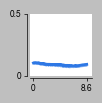

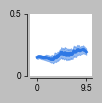

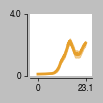

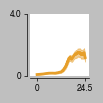

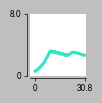

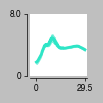

In [543]:
import pandas as pd
import pycircstat as pc

angles=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ecc_avgdata_r2_spill_fix.csv'),header=None))
masks=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','ang_avgmasks_r2_spill_fix.csv'),header=None))
r2=np.ravel(pd.read_csv(os.path.join(out_dir,'flatdata','r2_avgdata_r2_spill_fix.csv'),header=None))

coords=nb.load(os.path.join(out_dir,'flatdata','FLAT.coord.gii'))
x = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,0]) 
y = np.ravel(coords.get_arrays_from_intent(1008)[0].data[:,1]) 

# angles in pi
rot_mask = {
    'left_VI':0.25,
    'right_VI':0.75,
    'left_VIIb':0,#1.75,
    'right_VIIb':1,#1.25,
    'left_VIIIb':0.25,
    'right_VIIIb':0.75,
}

# create 1 figure for each mask with 3 different rotations
for mask in roi_order:
    
    f= pl.figure(figsize=(1,1))

    s = f.add_subplot(1,1,1)
    c = get_roi_color(mask)  
    
    rotation = rot_mask[mask]

    rx = np.ravel(rotate_via_numpy(x,y,rotation*np.pi)[0])
    v = (masks==mask_names[mask])
    v *= (np.invert(np.isnan(angles)))

    # create moving average
    # first sort values based on x
    order = np.argsort(rx[v])
    xo = rx[v][order]
    yo = angles[v][order]
    wo = r2[v][order]
    kw = int(v.sum()/kernel)

    ma_x = np.array([np.nanmean(xo[i:i+kw]) for i in range(v.sum()-kw)]) # these are the x coords
    ma_y = np.array([np.average(yo[i:i+kw],weights=wo[i:i+kw]) for i in range(v.sum()-kw)]) 
    ma_ci = np.array([DescrStatsW(yo[i:i+kw], weights=wo[i:i+kw]).std/np.sqrt(kw)*1.96 for i in range(v.sum()-kw)]) 


    pl.plot(ma_x,ma_y,lw=2,color=c)
    pl.fill_between(ma_x,ma_y-ma_ci,ma_y+ma_ci,alpha=0.5,color=c)

    pl.yticks([np.round(np.min(ma_y-ma_ci)),np.int(np.max(ma_y+ma_ci))])

    if (mask == 'left_VI') + (mask == 'right_VI'):
        pl.yticks([0,0.5],['0','0.5'])
        pl.ylim(0,0.5)
    elif (mask == 'left_VIIb') + (mask == 'right_VIIb'):
        pl.yticks([0,4],['0','4.0'])
        pl.ylim(0,4)
    elif (mask == 'left_VIIIb') + (mask == 'right_VIIIb'):
        pl.yticks([0,8],['0','8.0'])
        pl.ylim(0,8)

    
    #     pl.ylim([np.int(np.min(ma_y-ma_ci)),np.int(np.max(ma_y+ma_ci))])

#     else:
#         pl.ylim(0.5,1)
#     pl.yticks([])
#     pl.xticks([])
#     pl.xticks([np.min(ma_x),np.max(ma_x)])
    pl.xticks([np.min(ma_x),np.max(ma_x)],['0','%.1f'%(np.max(ma_x)-np.min(ma_x))])


    sn.despine(offset=2)

    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'angsurf_%s_single_ecc.pdf'%(mask)))#,dpi=500)




# make plots for the average subject cortical DAN / Visual network results

In [688]:
n_bins = 16

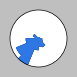

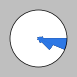

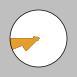

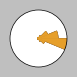

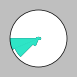

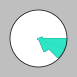

In [775]:
# polar histogram
for sub_type in sub_types:

    for mi,mask in enumerate(roi_order):
        f = pl.figure(figsize=(0.75,0.75))
        s = f.add_subplot(1,1,1,projection='polar')
        roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

        c = get_roi_color(mask)
        
        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            angles = np.ravel(data[roimask,dims['ang']])

        elif sub_type == 'per':
            all_angles = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_angles.append(np.ravel(data[roimask,dims['ang']]))

            angles = np.ravel(all_angles)
        
        angles = angles[~np.isnan(angles)]

        bins_number = n_bins
        bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
        radangs = np.radians(angles)
        n, _, _ = pl.hist(radangs, bins)

        width = 2 * np.pi / bins_number
        pl.bar(bins[:bins_number], n, width=width, bottom=0.0,ec=c,color=c)
#         for bar in bars:
#             bar.set_alpha(0.5)
        pl.xticks([])
        pl.yticks([])
        pl.ylim(0,np.max(n))

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'polar_histograms_%s_%s.pdf'%(sub_type,mask)))

In [748]:
avg_data = {}
for measure in ['ang','ecc','R2','rfsize']:
    avg_data[measure] = {}
    for hemi in ['lh','rh']:
        # load data
        fn = os.path.join(out_dir,'cortical_results','avgsub','%s.fit3_%s.mgz'%(hemi,measure))
        avg_data[measure][hemi] = np.squeeze(nb.load(fn).get_data())


In [749]:
rois = ['sPCS','iPCS','IPS','lateral','postCS','visual']

colors = ['#DE1F26','#189F49','#6053A3','#52C8EC','#FBAB43','#A34E9E']

/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


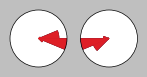

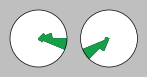

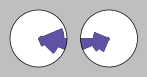

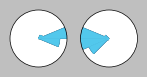

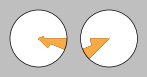

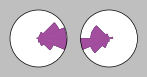

In [776]:

for ri,roi in enumerate(rois):
    f = pl.figure(figsize=(1.5,0.75))
    for hi,hemi in enumerate(['lh','rh']):
        s = f.add_subplot(1,2,hi+1,projection='polar')

        # get label roi
        label_fn = os.path.join(out_dir,'masks','labels','%s.%s.label'%(hemi,roi))
        # you can read the label files as csvs with pandas, skipping the first 2 rows
        # then, the first row is the indices of vertices belonging to that label
        data=np.array(pd.read_csv(label_fn,delimiter='  ',skiprows=2,header=None)[0]).astype(int)

        # then, we can convert this list of indices to a boolean array
        anat_mask = np.zeros(len(avg_data['ang'][hemi])).astype(bool)
        anat_mask[data] = True

        # get data
        angles = avg_data['ang'][hemi]
        r2 = avg_data['R2'][hemi]
        size = avg_data['rfsize'][hemi]
        ecc = avg_data['ecc'][hemi]
        
        # determine inclusive mask (i.e. which voxels to include)
        r2_mask = (r2>9.8) 
        nanmask = np.invert(np.isnan(angles))

        
        # add same fixation mark mask as in cerebellum data
        fixmask = (size>0.15)*(ecc>0.15)


        # combine and apply masks
        mask = (anat_mask * r2_mask * nanmask * fixmask)
        valid_angles = angles[mask]
        
        # create polar histogram
        bins = np.linspace(0.0, 2 * np.pi, n_bins + 1)
        radangs = np.radians(valid_angles)
        n, _, _ = pl.hist(radangs, bins)
        
        c = colors[ri]

        width = 2 * np.pi / n_bins
        pl.bar(bins[:n_bins], n, width=width, bottom=0.0,ec=c,color=c)
        pl.xticks([])
        pl.yticks([])
        pl.ylim(0,np.max(n))
        
    pl.tight_layout()

    f.savefig(os.path.join(fig_dir,'polar_hist_%s.pdf'%roi))#,dpi=500)




In [742]:

def gaussian(coords, mu, sig):
    return (np.exp(-np.power(coords - mu, 2.) / (2 * np.power(sig, 2.))))

def lateralities(ys,sigmas):
    lat  = []
    res = 1000
    for y,sigma in zip(ys,sigmas):
        if y != 0:
            prf = gaussian(np.linspace(-50,50,res),y,sigma) # resolution of 0.1 dva
            # top side over total: 
            # 0 means perfectly bottom, 
            # 1 means perfectly top, 
            # 0.5 means no up/down lateralization
            lat.append(np.sum(prf[int(res/2):]) / np.sum(prf)) 

    lat = np.array(lat)
    lat[np.isinf(lat)] = 1
    lat[np.isnan(lat)] = 0.5
    
    return lat

In [827]:
def get_y_lim(mask):
    
    maxecc=8
    if (mask in ['left_VI','right_VI']) + (mask =='VI'):
        maxecc = 0.2
    elif ('VIIb' in mask) + (mask=='VIIb'):
        maxecc = 0.3
    elif ('VIIIb' in mask) + (mask=='VIIIb'):
        maxecc = 5
            
    if mask == 'visual':
        maxecc = 6
    elif mask == 'lateral':
        maxecc = 4
    elif mask == 'IPS':
        maxecc = 6
    elif mask == 'iPCS':
        maxecc = 0.5
    elif mask == 'sPCS':
        maxecc = 2
    elif mask == 'postCS':
        maxecc = 4
    return maxecc



/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


lh: sPCS 59.6% of voxels below midline, t(790) = -17.86, p=0.000
rh: sPCS 87.3% of voxels below midline, t(1260) = -29.48, p=0.000
lh: iPCS 63.5% of voxels below midline, t(127) = -3.97, p=0.000
rh: iPCS 93.2% of voxels below midline, t(73) = -10.06, p=0.000
lh: IPS 66.8% of voxels below midline, t(3763) = -48.54, p=0.000
rh: IPS 78.0% of voxels below midline, t(4595) = -35.52, p=0.000
lh: lateral 37.6% of voxels below midline, t(1257) = 17.78, p=0.000
rh: lateral 60.7% of voxels below midline, t(1168) = 5.49, p=0.000
lh: postCS 88.8% of voxels below midline, t(881) = -15.67, p=0.000
rh: postCS 99.7% of voxels below midline, t(739) = -19.59, p=0.000
lh: visual 48.8% of voxels below midline, t(14411) = -3.22, p=0.001
rh: visual 57.1% of voxels below midline, t(15139) = -9.75, p=0.000


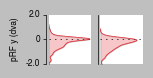

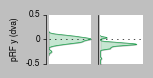

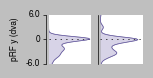

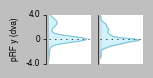

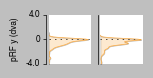

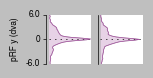

In [828]:
test_y = True
for ri,roi in enumerate(rois):
    f = pl.figure(figsize=(1.5,0.75))
    for hi,hemi in enumerate(['lh','rh']):
        s = f.add_subplot(1,2,hi+1)

        # get label roi
        label_fn = os.path.join(out_dir,'masks','labels','%s.%s.label'%(hemi,roi))
        data=np.array(pd.read_csv(label_fn,delimiter='  ',skiprows=2,header=None)[0]).astype(int)

        anat_mask = np.zeros(len(avg_data['ang'][hemi])).astype(bool)
        anat_mask[data] = True

        # get data
        angles = np.radians(avg_data['ang'][hemi])
        size = avg_data['rfsize'][hemi]
        ecc = avg_data['ecc'][hemi]
        r2 = avg_data['R2'][hemi]

        # convert to y coordinate
        y = ecc * np.sin(angles)
        
        # add same fixation mark mask as in cerebellum data
        fixmask = (size>0.15)*(ecc>0.15)

        # determine r2 mask
        r2_mask = (r2>9.8)
        nanmask = np.invert(np.isnan(angles))
        
        # combine masks
        mask = (anat_mask * r2_mask * nanmask * fixmask)
        
        # compute lateralities
        lats = lateralities(y[mask],size[mask])


        if test_y:
            t,p = sp.stats.ttest_1samp(y[mask],0)

            label = '%.1f'%(np.sum(y[mask]<0)/len(y[mask])*100)

            pl.axhline(0,color='k',ls=':')

#             sn.violinplot(y[mask],color=colors[ri],orient='v')#,shade=True,color=c,vertical=True,alpha=1)#wargs={'alpha':1})#label=label)
# /

            sn.kdeplot(y[mask],shade=True,c=colors[ri],vertical=True)
            maxecc = get_y_lim(roi)
            pl.ylim(-maxecc,maxecc)

#             pl.yticks([-max_ylim,0,max_ylim],['%.1f'%(-max_ylim),'0','%.1f'%max_ylim])\
            if hemi == 'lh':
                pl.ylabel('pRF y (dva)')
                pl.yticks([-maxecc,0,maxecc],['%.1f'%-maxecc,'0','%.1f'%maxecc])#,['-8','0','8'])


            else:
                pl.ylabel(' ')
                pl.yticks([])
        else:
            label = '%.1f'%(np.sum(lats<0.5)/len(lats)*100)
            t,p = sp.stats.ttest_1samp(lats,0.5)
            sn.kdeplot(lats,shade=True,c=colors[ri],vertical=True)
            pl.ylim(0,1)
            pl.yticks([0,0.5,1],['down','mid','up'])
            pl.axhline(0.5,color='k')


        print '%s: %s %s%s of voxels below midline, t(%d) = %.2f, p=%.3f'%(hemi,roi,label,'%',len(lats)-1,t,p)


        sn.despine(offset=2,bottom=True)

#         pl.xticks([-8,0,8])
#         pl.xlim(-8,8)
#         pl.xticks(s.get_xlim(),['%.1f'%s.get_xlim()[0],'%.1f'%s.get_xlim()[1]])
        pl.xticks([])
        
    pl.tight_layout()

    f.savefig(os.path.join(fig_dir,'lat_%s.pdf'%roi))#,dpi=500)

left_VI 89.9% of voxels below midline, t(98) = -10.28, p=0.000
right_VI 85.5% of voxels below midline, t(54) = -6.58, p=0.000
left_VIIb 84.9% of voxels below midline, t(158) = -7.18, p=0.000
right_VIIb 53.2% of voxels below midline, t(123) = -2.79, p=0.006
left_VIIIb 87.1% of voxels below midline, t(341) = -14.33, p=0.000
right_VIIIb 93.6% of voxels below midline, t(235) = -16.03, p=0.000


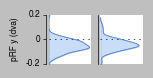

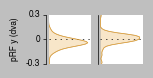

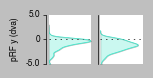

In [829]:
test_y = True
# polar histogram
for sub_type in sub_types:

    # first create a plot for the average subject
    for ri,roi in enumerate(['VI','VIIb','VIIIb']):
        f = pl.figure(figsize=(1.5,0.75))

        for hi,hemi in enumerate(['left','right']):

            mask = hemi+'_'+roi

            s = f.add_subplot(1,2,hi+1)
            roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

            c = get_roi_color(mask)

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            angles = np.ravel(data[roimask,dims['ang']])
            ecc = np.ravel(data[roimask,dims['ecc']])
            size = np.ravel(data[roimask,dims['rfsize']])

            y = ecc * np.sin(np.radians(angles))

            y = y[~np.isnan(y)]

            # compute lateralities
            lats = lateralities(y,size)
            maxecc = get_ecc_lim(mask,'avg')


            if test_y:
                t,p = sp.stats.ttest_1samp(y,0)

                label = '%.1f'%(np.sum(y<0)/len(y)*100)
                print '%s %s%s of voxels below midline, t(%d) = %.2f, p=%.3f'%(mask,label,'%',len(y)-1,t,p)

                pl.axhline(0,color='k',ls=":")            

                # create distplot of lateralities
                sn.kdeplot(y,shade=True,color=c,vertical=True)#wargs={'alpha':1})#label=label)

    #             sn.violinplot(y,color=c,orient='v')#,shade=True,color=c,vertical=True,alpha=1)#wargs={'alpha':1})#label=label)

                maxecc = get_y_lim(mask)
                pl.ylim(-maxecc,maxecc)
                if hemi == 'left':
                    pl.yticks([-maxecc,0,maxecc],['%.1f'%-maxecc,'0','%.1f'%maxecc])#,['-8','0','8'])
                    pl.ylabel('pRF y (dva)')           

                else:
                    pl.ylabel(' ')
                    pl.yticks([])        
            else:
                t,p = sp.stats.ttest_1samp(lats,0.5)

                label = '%.1f'%(np.sum(lats<0.5)/len(lats)*100)
                print '%s %s%s of voxels below midline, t(%d) = %.2f, p=%.3f'%(mask,label,'%',len(lats)-1,t,p)

                # create distplot of lateralities
                sn.kdeplot(lats,shade=True,color=c,vertical=True)#label=label)
        #         pl.legend(loc='best')

                pl.ylim(0,1)
                pl.yticks([0,0.5,1],['down','mid','up'])
                pl.axhline(0.5,color='k')
            sn.despine(offset=2,bottom=True)


    #         pl.xticks([-8,0,8])
    #         pl.xlim(-8,8)
    #         pl.xticks(s.get_xlim(),['%.1f'%s.get_xlim()[0],'%.1f'%s.get_xlim()[1]])
            pl.xticks([])


        

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'lat_avg_%s.pdf'%(roi)))

# timeseries plot

In [297]:
# Popeye imports
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus
import popeye.css as css
import popeye.og as og
import scipy as sp
from popeye.spinach import generate_og_receptive_fields

# Create stimulus design and define model
# ---------------------------------------
visual_dm_file = sp.io.loadmat(os.path.join(out_dir,'retinotopysmall5.mat'))
visual_dm = visual_dm_file['stim']

stimulus = VisualStimulus(  stim_arr = visual_dm,
                            viewing_distance = 102,
                            screen_width = 29,
                            scale_factor = 1,#/10.0,
                            tr_length = 1.0,
                            dtype = np.short)

model_func = css.CompressiveSpatialSummationModel(  stimulus = stimulus,
                                                    hrf_model = utils.spm_hrf)
model_func.hrf_delay = 0

# Get timeseries data
# ---------------------------------------
timeseries_fn = os.path.join(out_dir,'timeseries','avg_prf_timeseries.nii.gz')
timeseries_data = nb.load(timeseries_fn).get_data()

In [298]:
def two_d_gauss(xo, yo, sigma, amplitude = 1, theta=0,res=101,max_eccentricity=8):


    X = np.linspace(-max_eccentricity, max_eccentricity, res)
    Y = np.linspace(-max_eccentricity, max_eccentricity, res)
    MG = np.meshgrid(X, Y)

    (x,y) = MG    
    a = (np.cos(theta)**2)/(2*sigma**2) + (np.sin(theta)**2)/(2*sigma**2)
    b = -(np.sin(2*theta))/(4*sigma**2) + (np.sin(2*theta))/(4*sigma**2)
    c = (np.sin(theta)**2)/(2*sigma**2) + (np.cos(theta)**2)/(2*sigma**2)
    gauss = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

    return gauss

In [303]:
# create plot
# ---------------------------------------

n_vox = 5
ecc_bands = [[0,2],[2,4],[4,6],[6,8]]#[[2,4]]
for ecc_band in ecc_bands:
    for mi,mask in enumerate(roi_comb_order):#['lVIIIb']

        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data())
        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','split_masks.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        roimask = roimask.astype(bool)

        # now get prf results
        data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_avg.nii')).get_data()

    #     roimask *= np.isnan(data[:,:,:,dims['r2']])
        # get highest r squared
        eccs = data[:,:,:,dims['ecc']]
        valid_eccs = (eccs>ecc_band[0])*(eccs<ecc_band[1])
        
        roimask *= valid_eccs

        # apply mask to timeseries
        these_ts = copy.copy(timeseries_data)[roimask]

        these_r2s = []
        preds = []
        for v, t in enumerate(these_ts):
#             t = these_ts[v]
            # and prf parameters
            ang = np.radians(data[roimask,dims['ang']][v])
            ecc = data[roimask,dims['ecc']][v]

            x = ecc * np.cos(ang)
            y = ecc * np.sin(ang)
            size = data[roimask,dims['rfsize']][v]
            n = 0.05
            # calculate prediction
            pred = model_func.generate_prediction(x,y,size,n,1,0)

            # refit baseline and amp parameters (since using different packages)
            dm = np.mat(np.vstack([np.ones_like(pred),pred])).T
            intercept,slope = np.array(np.linalg.pinv(dm.T * dm) * dm.T * np.mat(t[:,np.newaxis]))     
            
            p =(intercept[0]+pred*slope[0])
            
            preds.append(p)
            these_r2s.append(sp.stats.pearsonr(p,t)[0]**2)
        
#         r2s = data[roimask,dims['r2']]
        best_voxels = np.argsort(these_r2s)[::-1][:n_vox]

        for best_voxel in best_voxels:

            # get this timeseries
            timeseries = these_ts[best_voxel]

            # zscore timeseries
            timeseries -= np.nanmean(timeseries)
            timeseries /= np.nanstd(timeseries)

            # and prf parameters
            ang = np.radians(data[roimask,dims['ang']][best_voxel])
            ecc = data[roimask,dims['ecc']][best_voxel]

            r2 = data[roimask,dims['r2']][best_voxel]

            x = ecc * np.cos(ang)
            y = ecc * np.sin(ang)
            size = data[roimask,dims['rfsize']][best_voxel]
            n = 0.05
            # calculate prediction
            pred = model_func.generate_prediction(x,y,size,n,1,0)

            # refit baseline and amp parameters (since using different packages)
            dm = np.mat(np.vstack([np.ones_like(pred),pred])).T
            intercept,slope = np.array(np.linalg.pinv(dm.T * dm) * dm.T * np.mat(timeseries[:,np.newaxis]))

            pred = (intercept[0]+pred*slope[0])
            thisr2 = (sp.stats.pearsonr(timeseries,pred)[0]**2)*100


            
            # generate pRF
            res = 501
            prf = two_d_gauss(x,y,size,res=res,max_eccentricity=stim_radius)**n


            f=pl.figure(figsize=(4,1.25))
            s = f.add_subplot(142,aspect='equal')
    #         pl.axhline(res/2,ls='-',c='k')
    #         pl.axvline(res/2,ls='-',c='k')

            # determine ecc limit and roi color
    #         maxecc = get_ecc_lim(mask,sub_type='avg',plot_type,)
            c = get_roi_color(mask)


            pl.axhline(0,lw=0.5,color='k')
            pl.axvline(0,lw=0.5,color='k')
            s.add_artist(pl.Circle((x,y),size, color='r',fill=False,alpha=0.25))
            pl.plot(x,y,'o',color='r',ms=3,mec='w',mew=1,alpha=1)
            pl.xlim(-stim_radius,stim_radius)
            pl.ylim(-stim_radius,stim_radius) 

    #         pl.imshow(prf,cmap='Greys',interpolation='nearest',origin='lowerleft')
    #         pl.xticks([0,res/2,res],[-stim_radius,0,stim_radius])
    #         pl.yticks([0,res/2,res],[-stim_radius,0,stim_radius])
            pl.xticks([-stim_radius,0,stim_radius])
            pl.yticks([-stim_radius,0,stim_radius])
            pl.xlabel('visual field x (dva)')
            pl.ylabel('visual field y (dva)')
            sn.despine(offset=2)
            pl.tight_layout()
            
            
            s = f.add_subplot(141)
            pl.text(0,0,'ecc: %.2f\nangle: %.2f\nsize: %.2f\nR2: %.2f'%(ecc,ang,size,thisr2),
                    horizontalalignment='right',verticalalignment='center')            
            pl.xlim(-5,5)
            pl.ylim(-5,5)
            pl.axis('off')

            

#             sn.despine(left=True,bottom=True)

#             f.savefig(os.path.join(fig_dir,'pred_%s_eccband_%s_v_%d_prf.pdf'%(mask,ecc_band,best_voxel)))#,dpi=500)


#             f=pl.figure(figsize=(4,1.25))

            s = f.add_subplot(122)
    
            pl.plot(timeseries,'o--',color='k',ms=1.5)
            pl.plot(pred,color='r',lw=1.5)
            ylims=s.get_ylim()
            
            pl.fill_between([0,16],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            
            pl.fill_between([16,48],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            pl.fill_between([48,80],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([80,112],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            pl.fill_between([112,144],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            
            pl.fill_between([144,156],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            
            pl.fill_between([156,188],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([188,220],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1)
            pl.fill_between([220,252],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')
            pl.fill_between([252,284],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='k',alpha=0.1) 
            
            pl.fill_between([284,300],[ylims[0],ylims[0]],[ylims[1],ylims[1]],color='w')             
                
#             pl.plot(timeseries,'o--',color='k',ms=1.5)
#             pl.plot(pred,color='r',lw=1.5)
#             ylims=s.get_ylim()
            
            sn.despine(offset=2)
    #         pl.
            pl.xlabel('time (s)')
            pl.ylabel('BOLD (z-score)')
            pl.tight_layout()

            f.savefig(os.path.join(fig_dir,'pred_%s_eccband_%s_v_%d.pdf'%(mask,ecc_band,best_voxel)))#,dpi=500)
            
            
            